定义卷积神经网络结构（cnn）：

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import joblib
import os
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 定义网络结构
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(     #input_size=(1*28*28)
            nn.Conv2d(1, 6, 5, 1, 2), #padding=2保证输入输出尺寸相同
            nn.ReLU(),      #input_size=(6*28*28)
            nn.MaxPool2d(kernel_size=2, stride=2),#output_size=(6*14*14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),      #input_size=(16*10*10)
            nn.MaxPool2d(2, 2)  #output_size=(16*5*5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    # 定义前向传播过程，输入为x
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # nn.Linear()的输入输出都是维度为一的值，所以要把多维度的tensor展平成一维
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    

设置训练的超参数以及训练所用的函数：

In [5]:
# 超参数设置
EPOCH = 8   #遍历数据集次数
BATCH_SIZE = 64      #批处理尺寸(batch_size)
LR = 0.001        #学习率

# 定义数据预处理方式
transform = transforms.ToTensor()

# 定义训练数据集
trainset = tv.datasets.MNIST(
    root='',
    train=True,
    download=False,
    transform=transform)

# 定义训练批处理数据
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    )

# 定义测试数据集
testset = tv.datasets.MNIST(
    root='',
    train=False,
    download=False,
    transform=transform)

# 定义测试批处理数据
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    )

# 定义损失函数loss function 和优化方式（采用SGD）
net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，通常用于多分类问题上
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

训练以及测试每轮训练后的准确率：

In [ ]:
# 训练


for epoch in range(EPOCH):
    sum_loss = 0.0
    # 数据读取
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 梯度清零
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每训练100个batch打印一次平均loss
        sum_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %d] loss: %.03f'
                  % (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
    # 每跑完一次epoch测试一下准确率
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            # 取得分最高的那个类
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('第%d个epoch的识别准确率为：%d%%' % (epoch + 1, (100 * correct / total)))
# torch.save(net.state_dict(), '%s/net_%03d.pth' % (opt.outf, epoch + 1))

保存训练好的模型：

In [10]:
torch.save(net.state_dict(),"MODEL/model2.pkl")

加载模型的函数：

In [4]:
#加载模型

def load_model(dir='MODEL', MODEL_NAME='model.pkl'):
    path = os.path.join(dir, MODEL_NAME)
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} 模型不存在，请先训练模型！")
    model = joblib.load(path)
    return model


加载模型：

In [12]:
net = LeNet()
# net = load_model(dir='MODEL', MODEL_NAME='model.pkl')
loaded_paras = torch.load("MODEL/model2.pkl")
net.load_state_dict(loaded_paras)
net.eval()

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

测试模型识别准确率：

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        # 取得分最高的那个类
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('模型识别准确率为：%f' % (correct / total))

模型识别准确率为：0.971800


Predicted number: 0


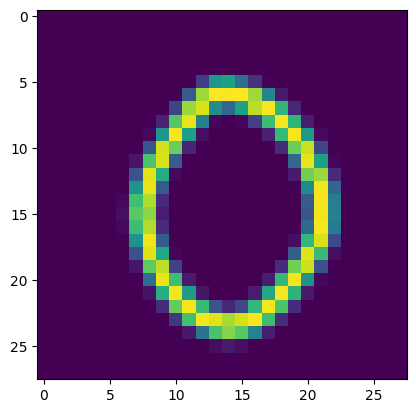

In [14]:
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import PIL

root = tk.Tk()
root.withdraw()

# 获取文件夹路径
image_path = filedialog.askopenfilename()
# print('\n获取的文件地址：', image_path)

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),  # 将图片转换为灰度图像
    transforms.ToTensor()
])

image = PIL.Image.open(image_path)
image = transform(image).unsqueeze(0)

# 进行预测
with torch.no_grad():
    output = net(image)
    _, predicted = torch.max(output, 1)

print('Predicted number:', predicted.item())
plt.imshow(image.view(28, 28))
plt.show()